#### Companion notebook for Alphalens tutorial lesson 4

# Advanced Alphalens concepts

You've learned the basics of using Alphalens. This lesson explores the following advanced Alphalens concepts:

1. Determining how far an alpha factor's decay rate.
2. Dealing with a common Alphalens error named MaxLossExceededError.
3. Grouping assets by sector, then analyzing each sector individually.
4. Writing group neutral strategies.

**All sections of this lesson will use the data produced by the Pipeline created in the following cell. Please run it.**

**Important note**: Until this lesson, we passed the output of `run_pipeline()` to `get_clean_factor_and_forward_returns()` without any changes. This was possible because the previous lessons' Pipelines only returned one column. This lesson's Pipeline returns two columns, which means we need to *specify the column* we're passing as factor data. Look for commented code near `get_clean_factor_and_forward_returns()` in the following cell to see how to do this.

ImportError: No module named 'quantopian.algorithm'

In [11]:
#import quantopian.algorithm as algo
import quantopian.optimize as opt
from quantopian.pipeline import Pipeline
from quantopian.pipeline.factors import SimpleMovingAverage
from quantopian.pipeline.data.factset import Fundamentals

from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.experimental import risk_loading_pipeline

from quantopian.pipeline.data.psychsignal import stocktwits
from quantopian.pipeline.data import Fundamentals

from quantopian.pipeline.data.morningstar import Fundamentals as morningFunda

import quantopian.pipeline.data.factset.estimates as fe
from quantopian.pipeline.data.factset.estimates import LongTermConsensus
from quantopian.pipeline.data import EquityPricing

from quantopian.pipeline import Pipeline
from quantopian.pipeline.data import factset
from quantopian.research import run_pipeline
from quantopian.pipeline.filters import QTradableStocksUS
from quantopian.pipeline.classifiers.fundamentals import Sector
from alphalens.utils import get_clean_factor_and_forward_returns

MAX_GROSS_LEVERAGE = 1.0
TOTAL_POSITIONS = 600

def make_pipeline():
    """
    A function that creates and returns our pipeline.

    We break this piece of logic out into its own function to make it easier to
    test and modify in isolation. In particular, this function can be
    copy/pasted into research and run by itself.

    Returns
    -------
    pipe : Pipeline
        Represents computation we would like to perform on the assets that make
        it through the pipeline screen.
    """
    # The factors we create here are based on fundamentals data and a moving
    # average of sentiment data
    value = Fundamentals.ebit.latest / Fundamentals.enterprise_value.latest
    quality = Fundamentals.roe.latest
    sentiment_score = SimpleMovingAverage(
        inputs=[stocktwits.bull_minus_bear],
        window_length=3,
    )
    total_revenue = Fundamentals.total_revenue.latest
    fq0_eps_cons = fe.PeriodicConsensus.slice('EPS', 'qf', 0)  
    fq0_eps_act = fe.Actuals.slice('EPS', 'qf', 0)
    fq0_eps_cons_mean = fq0_eps_cons.mean.latest
    fq0_eps_act_value = fq0_eps_act.actual_value.latest
    fq0_surprise = (fq0_eps_act_value - fq0_eps_cons_mean) / fq0_eps_cons_mean
    price_tgt_cons = fe.LongTermConsensus.slice('PRICE_TGT')
    eps_gr_cons = fe.LongTermConsensus.slice('EPS_LTG')
    price_tgt_mean = price_tgt_cons.mean.latest
    eps_gr_mean = eps_gr_cons.mean.latest
    yesterday_close = EquityPricing.close.latest
    est_price_growth = (price_tgt_mean - yesterday_close) / yesterday_close

    universe = QTradableStocksUS()

    # We winsorize our factor values in order to lessen the impact of outliers
    # For more information on winsorization, please see
    # https://en.wikipedia.org/wiki/Winsorizing
    value_winsorized = value.winsorize(min_percentile=0.05, max_percentile=0.95)
    quality_winsorized = quality.winsorize(min_percentile=0.05, max_percentile=0.95)
    sentiment_score_winsorized = sentiment_score.winsorize(
        min_percentile=0.05,
        max_percentile=0.95
        )
    total_revenue_winsorized = total_revenue.winsorize(min_percentile=0.05, max_percentile=0.95)
    fq0_surprise_winsorize=fq0_surprise.winsorize(min_percentile=0.05, max_percentile=0.95)
    est_price_growth_winsorize= est_price_growth.winsorize(min_percentile=0.05, max_percentile=0.95)
    
   


    # Here we combine our winsorized factors, z-scoring them to equalize their influence
    combined_factor = (
        value_winsorized.zscore() +
        quality_winsorized.zscore() +
        sentiment_score_winsorized.zscore() +
        total_revenue_winsorized.zscore() +
        fq0_surprise_winsorize.zscore() + 
        est_price_growth_winsorize.zscore()
    )

    # Build Filters representing the top and bottom baskets of stocks by our
    # combined ranking system. We'll use these as our tradeable universe each
    # day.
    longs = combined_factor.top(TOTAL_POSITIONS//2, mask=universe)
    shorts = combined_factor.bottom(TOTAL_POSITIONS//2, mask=universe)

    # The final output of our pipeline should only include
    # the top/bottom 300 stocks by our criteria
    long_short_screen = (longs | shorts)
    sector = Sector()

    # Create pipeline
    pipe = Pipeline(
        columns={
            'longs': longs,
            'shorts': shorts,
            'combined_factor': combined_factor,
            'sector': sector,
        },
        screen=long_short_screen
    )
    return pipe


pipeline_output = run_pipeline(make_pipeline(), '2013-1-1', '2014-1-1')
pricing_data = get_pricing(pipeline_output.index.levels[1], '2013-1-1', '2014-3-1', fields='open_price')


factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['combined_factor'], # How to analyze a specific pipeline column with Alphalens
    pricing_data, 
    periods=range(1,32,3)
)

Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


## Analyzing Alpha Factors By Group

Alphalens allows you to group assets using a classifier. A common use case for this is creating a classifier that specifies which sector each equity belongs to, then comparing your alpha factor's returns among sectors.

You can group assets by any classifier, but sector is most common. The Pipeline in the first cell of this lesson returns a column named `sector`, whose values represent the corresponding Morningstar sector code. All we have to do now is pass that column to the `groupby` argument of `get_clean_factor_and_forward_returns()`

**Run the following cell, and notice the charts at the bottom of the tear sheet showing how our factor performs in different sectors.**

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,0.048,0.041,0.033
beta,-0.137,-0.151,-0.133
Mean Period Wise Return Top Quantile (bps),0.815,0.380,0.149
Mean Period Wise Return Bottom Quantile (bps),1.397,1.664,1.543
Mean Period Wise Spread (bps),-0.581,-1.248,-1.359


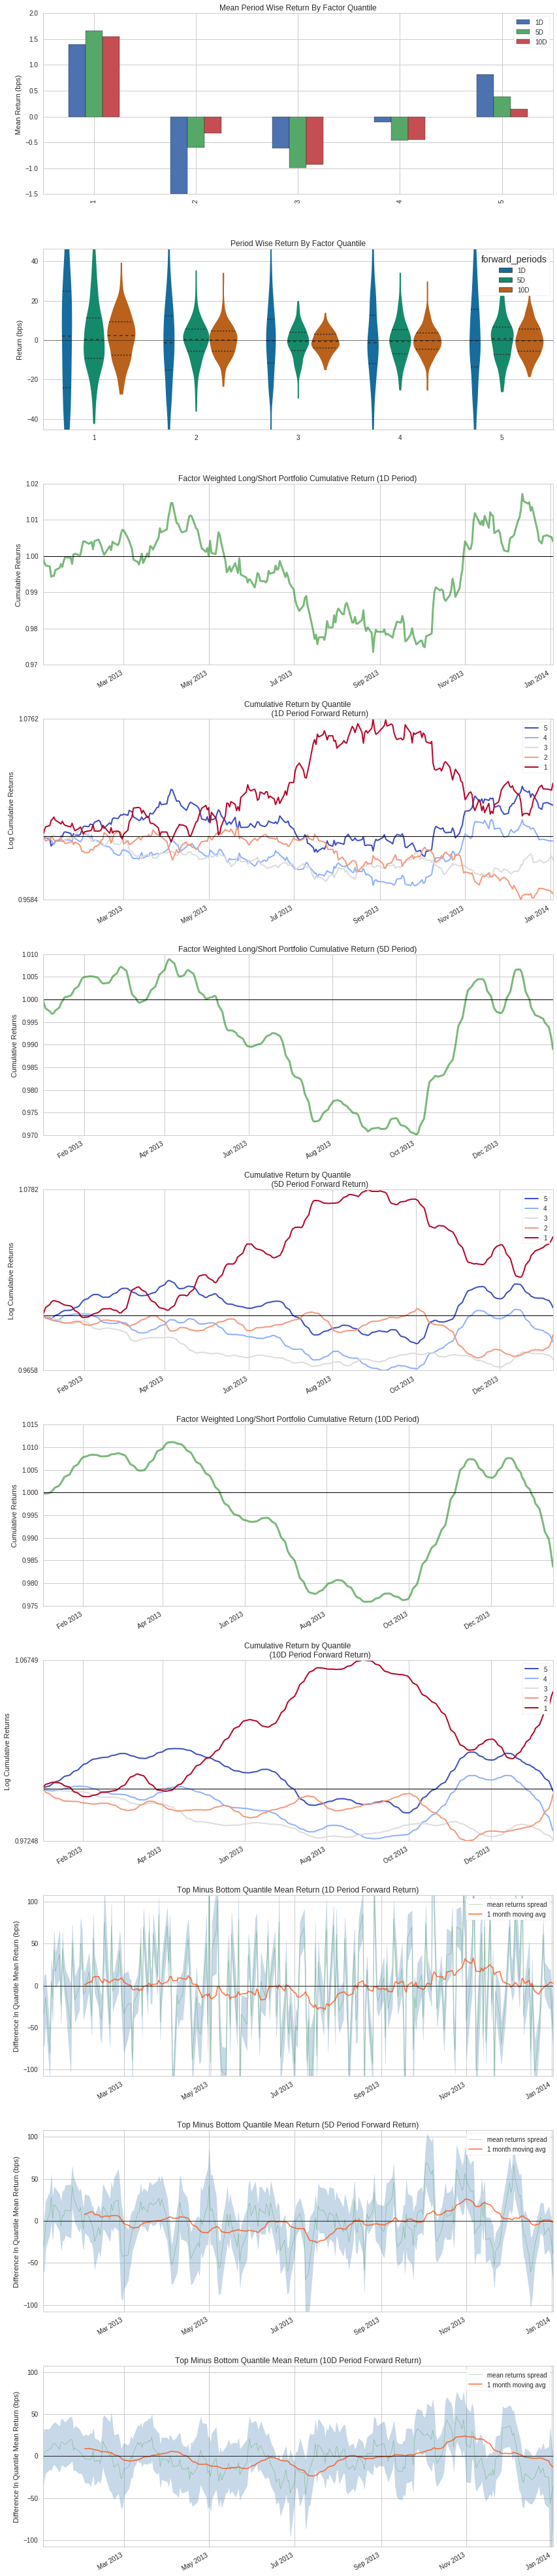

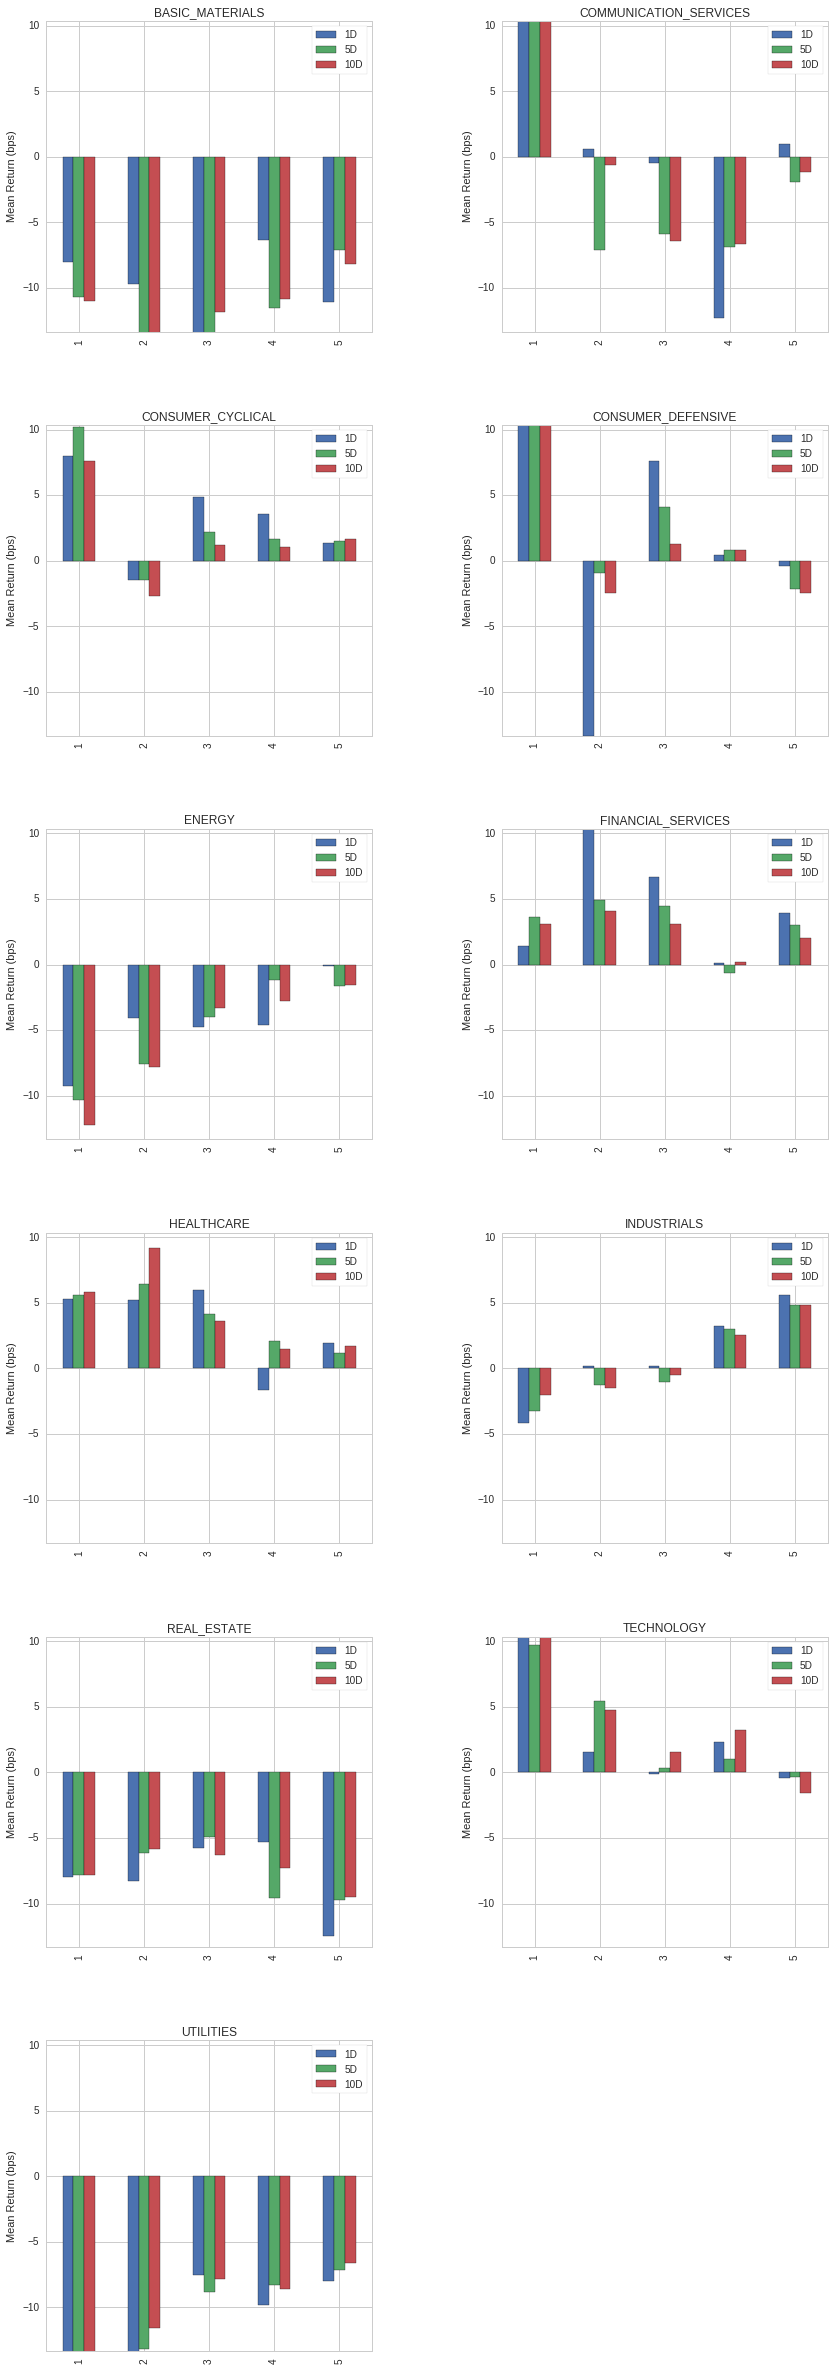

In [12]:
from alphalens.tears import create_returns_tear_sheet

sector_labels, sector_labels[-1] = dict(Sector.SECTOR_NAMES), "Unknown"

factor_data = get_clean_factor_and_forward_returns(
    factor=pipeline_output['combined_factor'],
    prices=pricing_data,
    groupby=pipeline_output['sector'],
    groupby_labels=sector_labels,
)

create_returns_tear_sheet(factor_data=factor_data, by_group=True)

## Writing Group Neutral Strategies

Not only does Alphalens allow us to simulate how our alpha factor would perform in a long/short trading strategy, it also allows us to simulate how it would do if we went long/short on every group! 

Grouping by sector, and going long/short on each sector allows you to limit exposure to the overall movement of sectors. For example, you may have noticed in step three of this tutorial, that certain sectors had all positive returns, or all negative returns. That information isn't useful to us, because that just means the sector group outperformed (or underperformed) the market; it doesn't give us any insight into how our factor performs within that sector.

Since we grouped our assets by sector in the previous cell, going group neutral is easy; just make the two following changes:
- Pass `binning_by_group=True` as an argument to `get_clean_factor_and_forward_returns()`.
- Pass `group_neutral=True` as an argument to `create_full_tear_sheet()`.

**The following cell has made the approriate changes. Try running it and notice how the results differ from the previous cell.**

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Returns Analysis


,1D,5D,10D
Ann. alpha,0.038,0.034,0.034
beta,-0.130,-0.138,-0.125
Mean Period Wise Return Top Quantile (bps),0.466,-0.231,-0.387
Mean Period Wise Return Bottom Quantile (bps),1.237,1.057,0.844
Mean Period Wise Spread (bps),-0.771,-1.282,-1.222


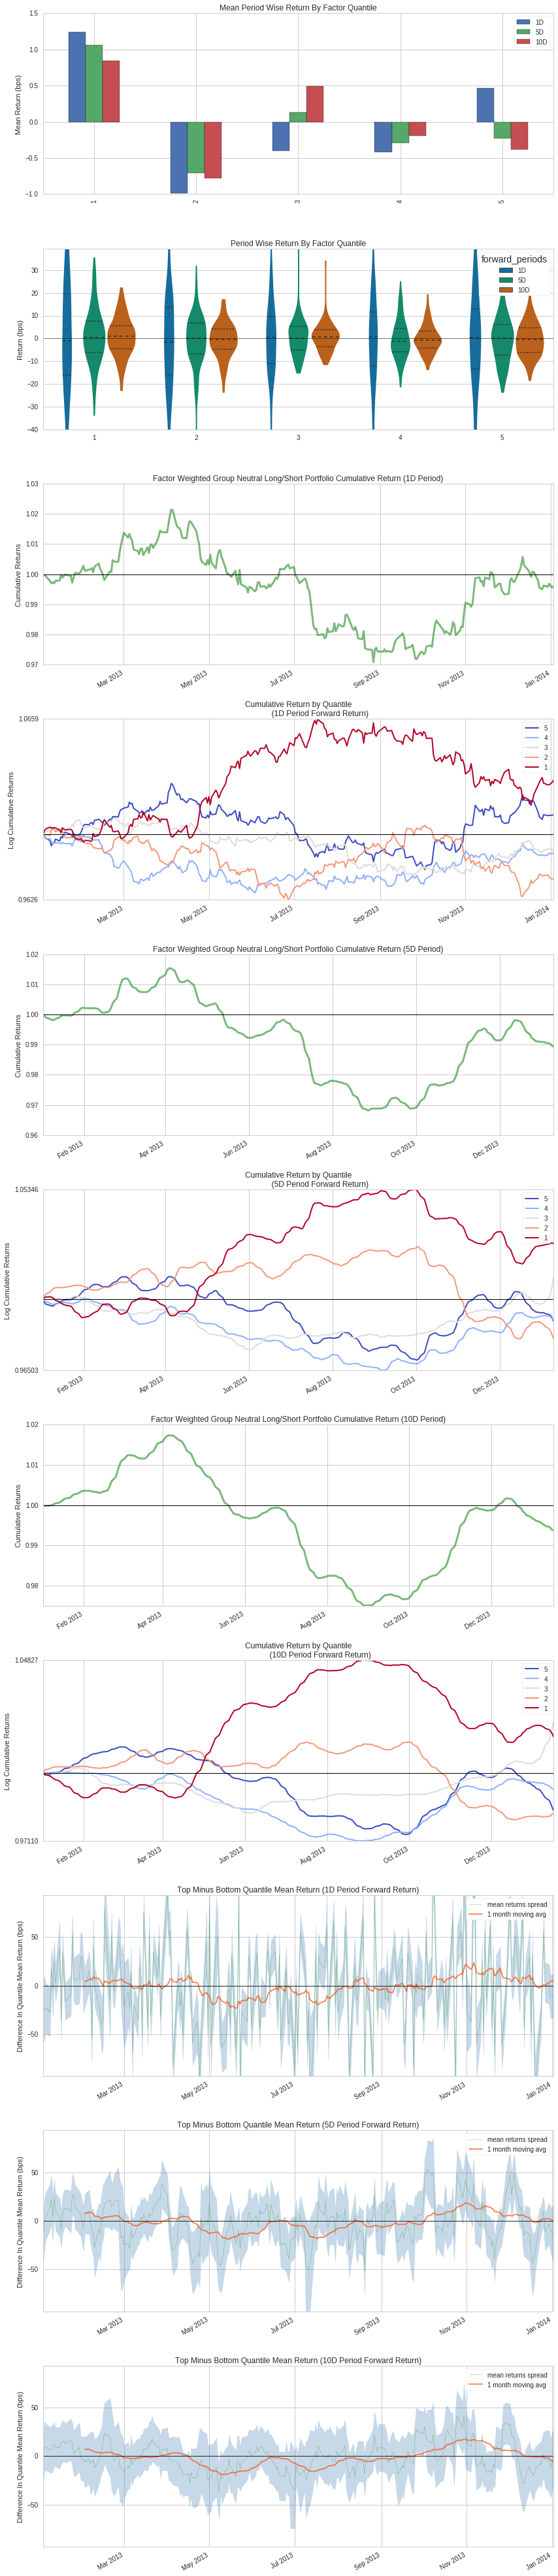

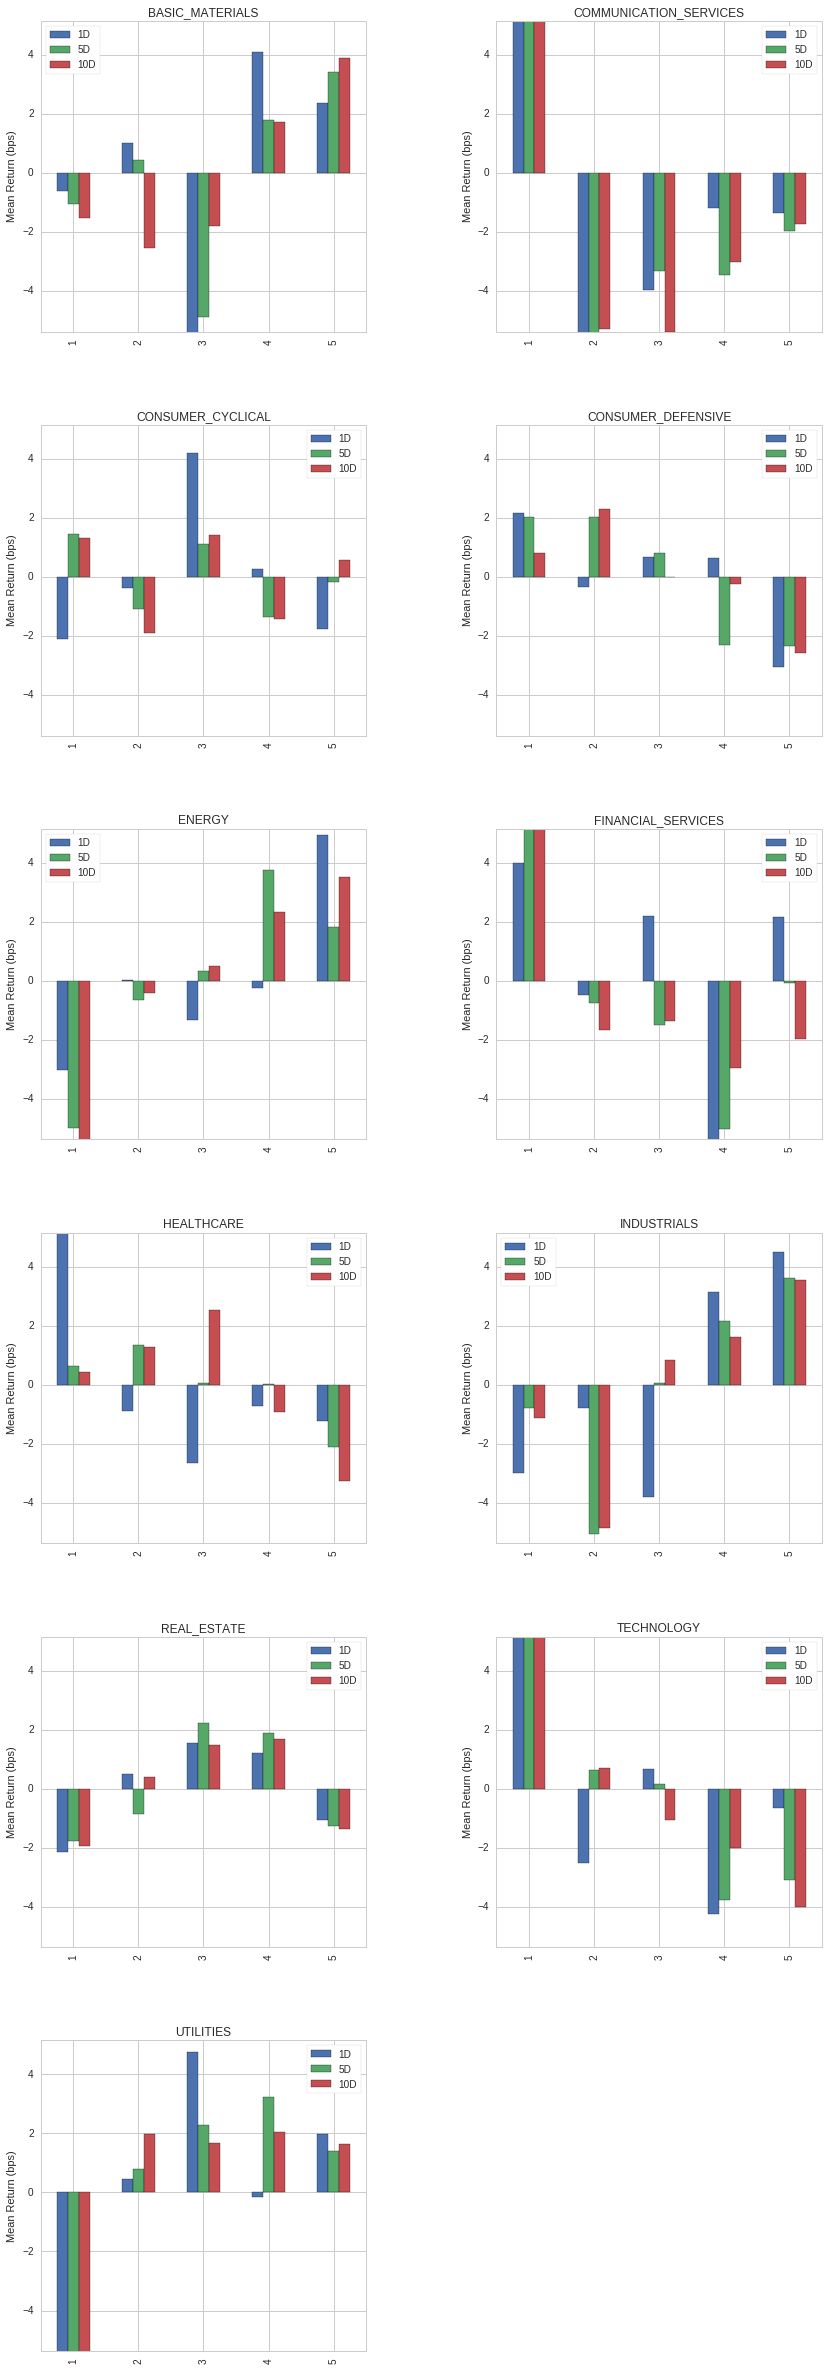

In [13]:
factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['combined_factor'],
    prices=pricing_data,
    groupby=pipeline_output['sector'],
    groupby_labels=sector_labels,
    binning_by_group=True,
)

create_returns_tear_sheet(factor_data, by_group=True, group_neutral=True)

## Visualizing An Alpha Factor's Decay Rate

A lot of fundamental data only comes out 4 times a year in quarterly reports. Because of this low frequency, it can be useful to increase the amount of time `get_clean_factor_and_forward_returns()` looks into the future to calculate returns. 

**Tip:** A month usually has 21 trading days, a quarter usually has 63 trading days, and a year usually has 252 trading days.

Let's say you're creating a strategy that buys stock in companies with rising profits (data that is released every 63 trading days). Would you only look 10 days into the future to analyze that factor? Probably not! But how do you decide how far to look forward?

**Run the following cell to chart our alpha factor's IC mean over time. The point where the line dips below 0 represents when our alpha factor's predictions stop being useful.**

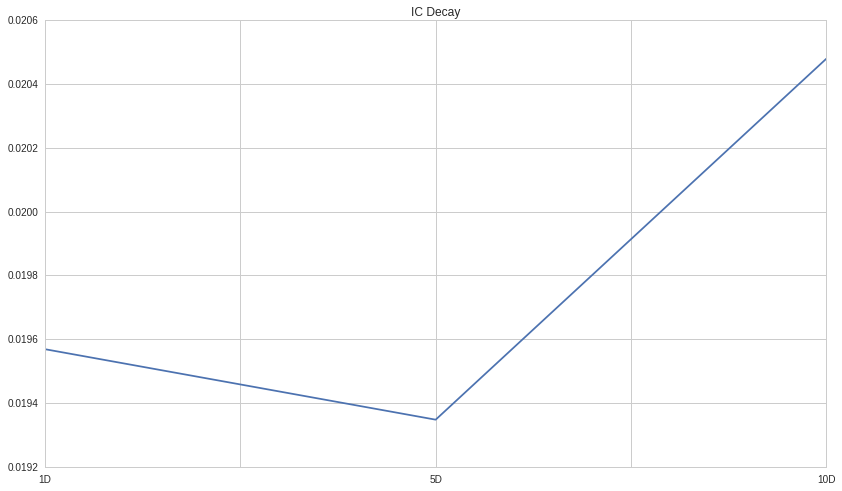

In [14]:
from alphalens.performance import mean_information_coefficient
mean_information_coefficient(factor_data).plot(title="IC Decay");

What do you think the chart will look like if we calculate the IC a full year into the future?

*Hint*: This is a setup for section two of this lesson.

## Dealing With MaxLossExceededError

Oh no! What does `MaxLossExceededError` mean?

`get_clean_factor_and_forward_returns()` looks at how alpha factor data affects pricing data *in the future*. This means we need our pricing data to go further into the future than our alpha factor data **by at least as long as our forward looking period.** 

In this case, we'll change `get_pricing()`'s `end_date` to be at least a year after `run_pipeline()`'s `end_date`.

**Run the following cell to make those changes. As you can see, this alpha factor's IC decays quickly after a quarter, but comes back even stronger six months into the future. Interesting!**

Dropped 2.3% entries from factor data: 2.3% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!


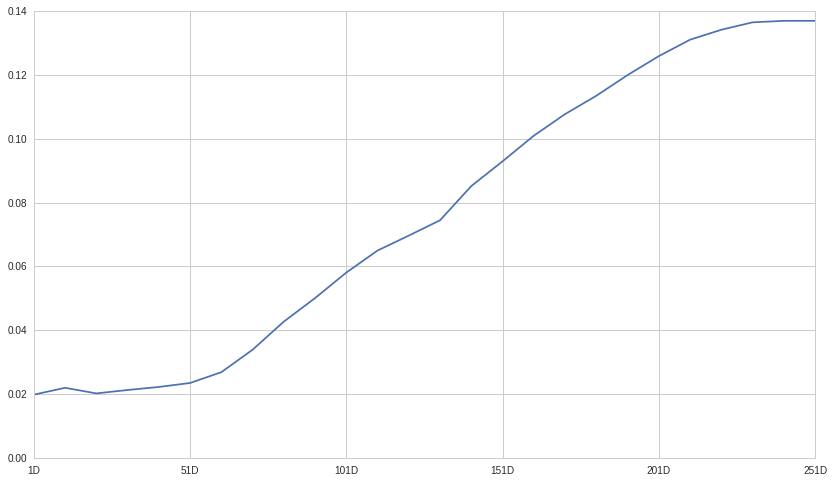

In [31]:
pipeline_output = run_pipeline(
    make_pipeline(),
    start_date='2013-1-1', 
    end_date='2014-1-1' #  *** NOTE *** Our factor data ends in 2014
)

pricing_data = get_pricing(
    pipeline_output.index.levels[1], 
    start_date='2013-1-1',
    end_date='2015-2-1', # *** NOTE *** Our pricing data ends in 2015
    fields='open_price'
)

factor_data = get_clean_factor_and_forward_returns(
    pipeline_output['combined_factor'], 
    pricing_data,
    periods=range(1,252,10) # Change the step to 10 or more for long look forward periods to save time
)

mean_information_coefficient(factor_data).plot()

*Note: MaxLossExceededError has two possible causes; forward returns computation and binning. We showed you how to fix forward returns computation here because it is much more common. Try passing `quantiles=None` and `bins=5` if you get MaxLossExceededError because of binning.*

That's it! This tutorial got you started with Alphalens, but there's so much more to it. Check out our [API docs](http://quantopian.github.io/alphalens/) to see the rest!